In [40]:
import random
from scipy.io import loadmat
import h5py
import numpy as np
from PIL import Image

IMAGE_PATH = "/Volumes/Rembr2Eject/nsd_stimuli.hdf5"
EXP_PATH = "stimulus/nsd_expdesign.mat"


In [2]:
def validate_block(block_trials):
    prev = -1
    for trial in block_trials:
        if trial == prev:
            return False
        prev = trial
    return True

def create_trials(n_images, n_oddballs, num_blocks):
    trials = []

    for block in range(num_blocks):
        isValidBlock = False
        block_trials = []
        while not isValidBlock:
            # Generate trials for each block
            start = block * n_images + 1
            end = start + n_images
            images = list(range(start, end))
            oddballs = [-1] * n_oddballs
            block_trials = images + oddballs
            random.shuffle(block_trials)
            # ensure no two consecutive trials are the same.
            # legacy code when we repeated images in a block
            isValidBlock = validate_block(block_trials)

        for idx, trial in enumerate(block_trials):
            trials.append({'block': (block + 1), 'image': trial, 'end_of_block': (idx == len(block_trials) - 1)})

    return trials


In [31]:
# Parameters
n_images = 208  # Number of unique images per block
n_oddballs = 24  # Number of oddball images per block
num_blocks = 16  # Number of blocks
img_width, img_height = 425, 425  # Define image dimensions

trials = create_trials(n_images, n_oddballs, num_blocks)

subj = 1
session = 1

def getNsdIndices(subj, session):
    totalImages = n_images * num_blocks
    # Mapping from integer id to NSD id
    mat = loadmat(EXP_PATH)
    subjectim = mat['subjectim'] # 1-indexed
    image_indices = subjectim[int(subj)-1][(int(session)-1)*totalImages : int(session)*totalImages]
    return image_indices

img_map = getNsdIndices(subj, session)
img_map = img_map -1 # img_map is 1-indexed
sorted_indices = np.argsort(img_map)
inverse_indices = np.argsort(sorted_indices)  # To revert back to original order


In [37]:
with h5py.File(IMAGE_PATH, 'r') as file:
    dataset = file["imgBrick"]
    testImage = dataset[img_map[0], :, :, :]  # Assuming index is within the valid range for dataset # pyright: ignore

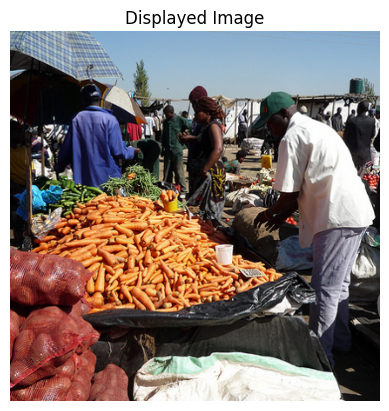

In [38]:
plt.imshow(testImage)
plt.title('Displayed Image')
plt.axis('off')  # Hide axes ticks
plt.show()

In [32]:
with h5py.File(IMAGE_PATH, 'r') as file:
    dataset = file["imgBrick"]
    sorted_images = dataset[img_map[sorted_indices], :, :, :]  # Assuming index is within the valid range for dataset # pyright: ignore
    images = sorted_images[inverse_indices]
    # image = Image.fromarray(image) # pyright: ignore
    # last_image = image
    print(images.shape)

(3328, 425, 425, 3)


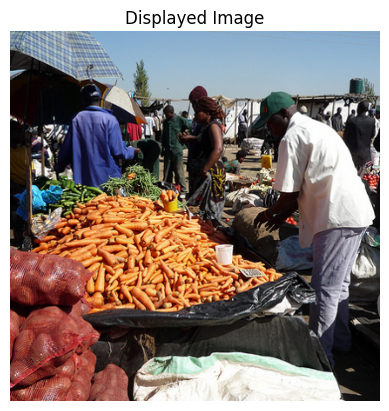

In [33]:
import matplotlib.pyplot as plt
plt.imshow(images[0])
plt.title('Displayed Image')
plt.axis('off')  # Hide axes ticks
plt.show()

In [ ]:

for idx, trial in enumerate(trials):
    if trial['block'] != current_block:
        current_block = trial['block']
        start_index = (current_block - 1) * n_images
        end_index = start_index + n_images
        print(f"\nBlock {current_block}, Start Index: {start_index}")
        print(f"Block {current_block}, End Index: {end_index}\n")
    
    # Check if this trial is an oddball
    is_oddball = (trial['image'] == -1)
    if is_oddball:
        image = last_image
    else:
        nsd_id = img_map[trial['image'] - 1] # Recall that trial and img_map is 1-indexed
        # Adjust index for 0-based Python indexing
        with h5py.File(IMAGE_PATH, 'r') as file:
            dataset = file["imgBrick"]
            import pdb
            pdb.set_trace()
            image = dataset[nsd_id-1, :, :, :]  # Assuming index is within the valid range for dataset # pyright: ignore
            image = Image.fromarray(image) # pyright: ignore
        last_image = image

    # Record trigger
    await record_trigger(trial['image'], websocket, debug_mode=False)

    # Append current image number to the sequence list
    image_sequence.append(trial['image'])

    # Logging the trial details
    print(f"Block {trial['block']}, Trial {idx + 1}: Image {trial['image']} {'(Oddball)' if is_oddball else ''}")

    # Display the image
    image_stim = visual.ImageStim(win=window, image=image, pos=(0, 0), size=(img_width, img_height))
    image_stim.draw()
    window.flip()
    core.wait(0.3)  # Display time

In [43]:
def getImages(subj, session, n_images, num_blocks):
    totalImages = n_images * num_blocks
    # Mapping from integer id to NSD id
    mat = loadmat(EXP_PATH)
    subjectim = mat['subjectim'] # 1-indexed

    image_indices = subjectim[int(subj)-1][(int(session)-1)*totalImages : int(session)*totalImages]
    image_indices = image_indices -1 # img_map is 1-indexed
    sorted_indices = np.argsort(image_indices)
    inverse_indices = np.argsort(sorted_indices)  # To revert back to original order

    with h5py.File(IMAGE_PATH, 'r') as file:
        dataset = file["imgBrick"]
        sorted_images = dataset[img_map[sorted_indices], :, :, :]  # Assuming index is within the valid range for dataset # pyright: ignore
        images = sorted_images[inverse_indices]
        pil_images = [Image.fromarray(img) for img in images]
    return pil_images

In [44]:
images = getImages(1, 1, n_images, num_blocks)

In [46]:
len(images)

3328